In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, BoundaryNorm, LinearSegmentedColormap
import pandas as pd
import string
import xarray as xr

In [2]:
### Load data
parent_dir = '/pl/active/WRFLES_GAD/wfp_3dpbl/idealized/neutral/'

## MYNN
dsn_m = xr.open_dataset(parent_dir+'dsn_m.nc')
dst_m = xr.open_dataset(parent_dir+'dst_m.nc')
dsz_m = xr.open_dataset(parent_dir+'dsz_m.nc')

## NCAR-HV
dsn_hv = xr.open_dataset(parent_dir+'dsn_hv.nc')
dst_hv = xr.open_dataset(parent_dir+'dst_hv.nc')
dsz_hv = xr.open_dataset(parent_dir+'dsz_hv.nc')

In [3]:
### Pull key parameters out of WRF files
###   Assume matching coords
nlon_unstag = len(dsn_m['west_east'])
nlat_unstag = len(dsn_m['south_north'])
nlon_stag = nlon_unstag + 1
nlat_stag = nlat_unstag +1

iunstag_arr = np.arange(nlon_unstag)+1-111+1
junstag_arr = np.arange(nlat_unstag)+1-111+1

heights = dsn_m['HEIGHT'].values
heights_stag = dsn_m['HEIGHT_STAG'].values

In [4]:
### Read turbine data
turbine_file = '/projects/olry2348/WFIP2-WRF-3DPBL/runs/idealized/neutral/mynn-ztke/windturbines-ij.txt'
turbine_df = pd.read_csv(turbine_file, delim_whitespace=True, usecols=[0,1], names=['i', 'j'])

turbine_properties = '/projects/olry2348/WFIP2-WRF-3DPBL/runs/idealized/neutral/mynn-ztke/wind-turbine-1.tbl'
f = open(turbine_properties, "r")
lines = f.readlines()
hubheight = np.float(lines[1].split()[0])
rotor_diameter = np.float(lines[1].split()[1])
rotor_top = hubheight + rotor_diameter/2
rotor_bot = hubheight - rotor_diameter/2

print("Hub height", hubheight)
print("Rotor diameter", rotor_diameter)

Hub height 138.0
Rotor diameter 215.0


In [5]:
cols = ['Wspd', 'Thrust', 'Power']
property_df = np.zeros((len(lines[2:]), 3))
for i in range(len(property_df)):
    line = lines[2+i]
    property_df[i,0] = np.float(line.split()[0])
    property_df[i,1] = np.float(line.split()[1])
    property_df[i,2] = np.float(line.split()[2])
property_df = pd.DataFrame(property_df, columns=cols)
property_df = property_df.set_index('Wspd')

# NWF conditions
Examine conditions at the location inside the farm

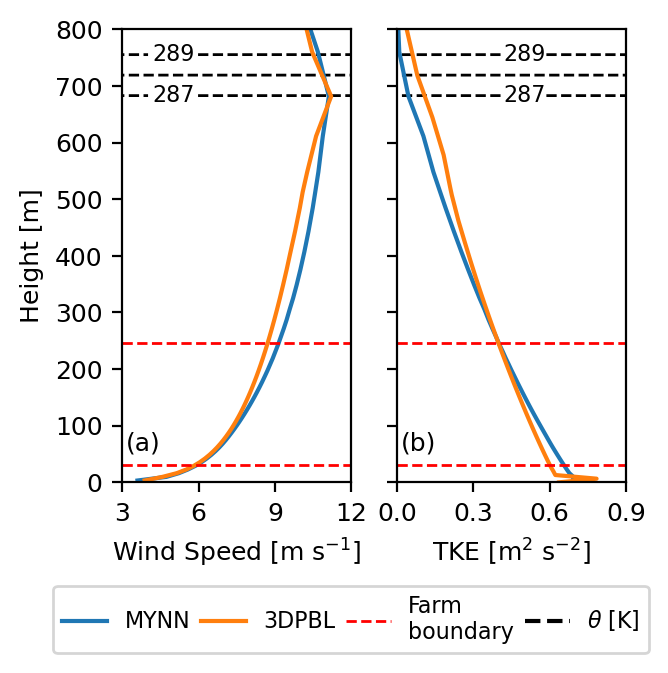

In [6]:
### Profiles of key variables
fig, ax = plt.subplots(1, 2, figsize=(3.25,3), sharey=True, dpi=200)

wspd_nm = dsn_m['WSPD'].isel(south_north=slice(89,109), west_east=slice(89,109)).mean(('south_north', 'west_east'))
wspd_nhv = dsn_hv['WSPD'].isel(south_north=slice(89,109), west_east=slice(89,109)).mean(('south_north', 'west_east'))

tke_nm = dsn_m['TKE'].isel(south_north=slice(89,109), west_east=slice(89,109)).mean(('south_north', 'west_east'))
tke_nhv = dsn_hv['TKE'].isel(south_north=slice(89,109), west_east=slice(89,109)).mean(('south_north', 'west_east'))

wspd_nm_hh_mean = dsn_m['WSPD'].isel(south_north=slice(89,109), 
                                     west_east=slice(89,109), 
                                     bottom_top=slice(20,22)).mean(('south_north', 
                                                                    'west_east', 
                                                                    'bottom_top')).values

wspd_nhv_hh_mean = dsn_hv['WSPD'].isel(south_north=slice(89,109), 
                                     west_east=slice(89,109), 
                                     bottom_top=slice(20,22)).mean(('south_north', 
                                                                    'west_east', 
                                                                    'bottom_top')).values

tke_nm_hh_mean = dsn_m['TKE'].isel(south_north=slice(89,109), 
                                     west_east=slice(89,109), 
                                     bottom_top=slice(20,22)).mean(('south_north', 
                                                                    'west_east', 
                                                                    'bottom_top')).values

tke_nhv_hh_mean = dsn_hv['TKE'].isel(south_north=slice(89,109), 
                                     west_east=slice(89,109), 
                                     bottom_top_stag=21).mean(('south_north', 
                                                                    'west_east')).values

ax[0].plot(wspd_nm, heights, label='MYNN')
ax[0].plot(wspd_nhv, heights, label='3DPBL')

ax[1].plot(tke_nm, heights, label='MYNN')
ax[1].plot(tke_nhv, heights_stag, label='3DPBL')


# ax[0].set_title(f'MYNN Hub-Height Mean:\n{wspd_nm_hh_mean:.2f}\n3DPBL Hub-Height Mean:\n{wspd_nhv_hh_mean:.2f}')
# ax[1].set_title(f'MYNN Hub-Height Mean:\n{tke_nm_hh_mean:.2f}\n3DPBL Hub-Height Mean:\n{tke_nhv_hh_mean:.2f}')

ax[0].axhline(rotor_top, color='r', lw=1, ls='--', label='Farm\nboundary')
ax[0].axhline(rotor_bot, color='r', lw=1, ls='--')
ax[1].axhline(rotor_top, color='r', lw=1, ls='--', label='Farm\nboundary')
ax[1].axhline(rotor_bot, color='r', lw=1, ls='--')

ax[0].set_xlabel('Wind Speed [m s$^{-1}$]', fontsize=9)
ax[1].set_xlabel("TKE [m$^2$ s$^{-2}$]", fontsize=9)
ax[0].set_ylabel("Height [m]", fontsize=9)

ax[0].set_ylim(0, 800)
ax[0].set_xlim(3, 12)
ax[1].set_xlim(0, 0.8)

## Temperature contours
t_nm = dsn_m['T'].mean('south_north')
t_nhv = dsn_hv['T'].mean('south_north')
ticks_t = np.arange(286, 290, 1)


CS = ax[0].contour(iunstag_arr,
                   heights,
                   t_nm,
                   ticks_t,
                   colors='k',
                   linestyles='dashed',
                   linewidths=1)
manual_locations = [(5.0, 650), (5.0, 750)]
ax[0].clabel(CS, inline=True, manual=manual_locations, fmt='%3.0f', fontsize=8)

CS = ax[1].contour(iunstag_arr,
                   heights,
                   t_nm,
                   ticks_t,
                   colors='k',
                   linestyles='dashed',
                   linewidths=1)
manual_locations = [(0.5, 650), (0.5, 750)]
ax[1].clabel(CS, inline=True, manual=manual_locations, fmt='%3.0f', fontsize=8)


# ## Hacky approach for legend
ax[1].plot([-9999, -9999], [0, 1], ls='--', color='k', label='$\\theta$ [K]')

ax[0].tick_params(labelsize=9)
ax[1].tick_params(labelsize=9)

ax[0].text(0.17,
          0.07,
          '(a)',
          fontsize=9,
          transform = ax[0].transAxes,
          horizontalalignment='right',
            color='black')
ax[1].text(0.17,
          0.07,
          '(b)',
          fontsize=9,
          transform = ax[1].transAxes,
          horizontalalignment='right',
            color='black')

handles, labels = ax[1].get_legend_handles_labels()
lgd = ax[1].legend(handles, labels, bbox_to_anchor=(-1.5, -0.33, 2.6, .102), loc='upper left', fontsize=8, ncol=4, mode='expand',borderaxespad=0.)

ax[0].set_xticks([3, 6, 9, 12])
ax[1].set_xticks([0, 0.3, 0.6, 0.9])

# plt.savefig('../../figs/neutral_nwf_profile.pdf', bbox_inches='tight', bbox_extra_artists=[lgd],)

plt.show()

# Tendencies

### Vertical tendencies

In [7]:
### Calculate tendencies
## Vertical component
# u-tendency
dsn_m_utend_z = dsn_m.assign_coords({'bottom_top_stag':heights_stag})['UPWP'].differentiate('bottom_top_stag') * 86400  # m/s/hr
dsn_m_utend_z.name = 'UTEND_Z'
dsz_m_utend_z = dsz_m.assign_coords({'bottom_top_stag':heights_stag})['UPWP'].differentiate('bottom_top_stag') * 86400  # m/s/hr
dsz_m_utend_z.name = 'UTEND_Z'
dst_m_utend_z = dst_m.assign_coords({'bottom_top_stag':heights_stag})['UPWP'].differentiate('bottom_top_stag') * 86400  # m/s/hr
dst_m_utend_z.name = 'UTEND_Z'

dsn_hv_utend_z = dsn_hv.assign_coords({'bottom_top_stag':heights_stag})['UPWP'].differentiate('bottom_top_stag') * 86400  # m/s/hr
dsn_hv_utend_z.name = 'UTEND_Z'
dsz_hv_utend_z = dsz_hv.assign_coords({'bottom_top_stag':heights_stag})['UPWP'].differentiate('bottom_top_stag') * 86400  # m/s/hr
dsz_hv_utend_z.name = 'UTEND_Z'
dst_hv_utend_z = dst_hv.assign_coords({'bottom_top_stag':heights_stag})['UPWP'].differentiate('bottom_top_stag') * 86400  # m/s/hr
dst_hv_utend_z.name = 'UTEND_Z'

# v-tendency
dsn_m_vtend_z = dsn_m.assign_coords({'bottom_top_stag':heights_stag})['VPWP'].differentiate('bottom_top_stag') * 86400  # m/s/hr
dsn_m_vtend_z.name = 'VTEND_Z'
dsz_m_vtend_z = dsz_m.assign_coords({'bottom_top_stag':heights_stag})['VPWP'].differentiate('bottom_top_stag') * 86400  # m/s/hr
dsz_m_vtend_z.name = 'VTEND_Z'
dst_m_vtend_z = dst_m.assign_coords({'bottom_top_stag':heights_stag})['VPWP'].differentiate('bottom_top_stag') * 86400  # m/s/hr
dst_m_vtend_z.name = 'VTEND_Z'

dsn_hv_vtend_z = dsn_hv.assign_coords({'bottom_top_stag':heights_stag})['VPWP'].differentiate('bottom_top_stag') * 86400  # m/s/hr
dsn_hv_vtend_z.name = 'VTEND_Z'
dsz_hv_vtend_z = dsz_hv.assign_coords({'bottom_top_stag':heights_stag})['VPWP'].differentiate('bottom_top_stag') * 86400  # m/s/hr
dsz_hv_vtend_z.name = 'VTEND_Z'
dst_hv_vtend_z = dst_hv.assign_coords({'bottom_top_stag':heights_stag})['VPWP'].differentiate('bottom_top_stag') * 86400  # m/s/hr
dst_hv_vtend_z.name = 'VTEND_Z'

### Wind speed differences and tendency differences
I will only look at the z-component of the tendencies, as it dominates

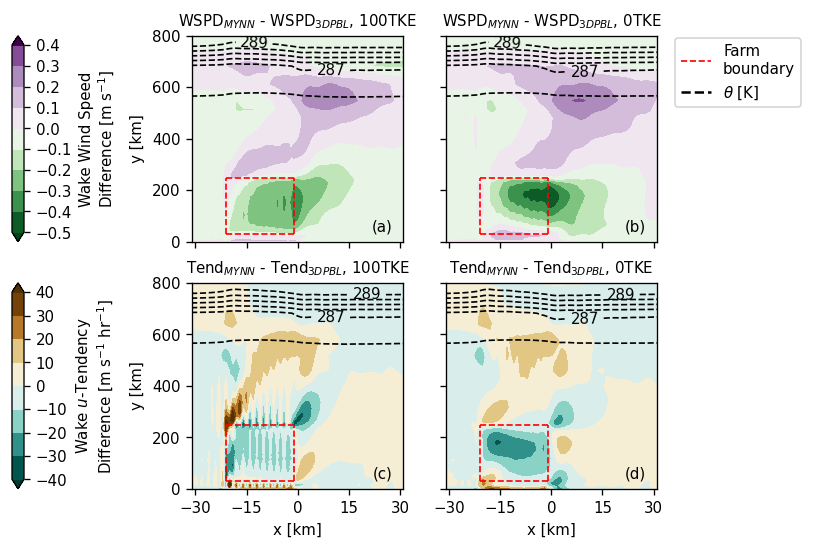

In [8]:
### AVERAGED DEFICITS
fig, ax = plt.subplots(2, 2, figsize=(5,5), sharex=True, sharey=True, dpi=120)

## Plot parameters
ticks_left = np.arange(-0.5, 0.5, 0.1)
ticks_right = np.arange(-40, 50, 10)
ticks_t = np.arange(286, 289.5, 0.5)
j_ind = 101
j_ind_min = 89
j_ind_max = 109

## Select wind speed slices
wspd_nm = dsn_m['WSPD'].isel(south_north=slice(j_ind_min,j_ind_max)).mean('south_north')
wspd_tm = dst_m['WSPD'].isel(south_north=slice(j_ind_min,j_ind_max)).mean('south_north')
wspd_zm = dsz_m['WSPD'].isel(south_north=slice(j_ind_min,j_ind_max)).mean('south_north')
wspd_nhv = dsn_hv['WSPD'].isel(south_north=slice(j_ind_min,j_ind_max)).mean('south_north')
wspd_thv = dst_hv['WSPD'].isel(south_north=slice(j_ind_min,j_ind_max)).mean('south_north')
wspd_zhv = dsz_hv['WSPD'].isel(south_north=slice(j_ind_min,j_ind_max)).mean('south_north')


## Select tendency slices
utend_nm = -1*dsn_m_utend_z.isel(south_north=slice(j_ind_min,j_ind_max)).mean('south_north')
utend_tm = -1*dst_m_utend_z.isel(south_north=slice(j_ind_min,j_ind_max)).mean('south_north')
utend_zm = -1*dsz_m_utend_z.isel(south_north=slice(j_ind_min,j_ind_max)).mean('south_north')
utend_nhv = -1*dsn_hv_utend_z.isel(south_north=slice(j_ind_min,j_ind_max)).mean('south_north')
utend_thv = -1*dst_hv_utend_z.isel(south_north=slice(j_ind_min,j_ind_max)).mean('south_north')
utend_zhv = -1*dsz_hv_utend_z.isel(south_north=slice(j_ind_min,j_ind_max)).mean('south_north')

im1 = ax[0,0].contourf(iunstag_arr,
                        heights,
                        (wspd_tm-wspd_nm)-(wspd_thv-wspd_nhv),
                        ticks_left,
                        cmap=plt.cm.PRGn_r, norm=TwoSlopeNorm(0, vmin=-1*np.abs(ticks_left).max(), vmax=np.abs(ticks_left).max()),
                        extend='both')
im1 = ax[0,1].contourf(iunstag_arr,
                        heights,
                        (wspd_zm-wspd_nm)-(wspd_zhv-wspd_nhv),
                        ticks_left,
                        cmap=plt.cm.PRGn_r, norm=TwoSlopeNorm(0, vmin=-1*np.abs(ticks_left).max(), vmax=np.abs(ticks_left).max()),
                        extend='both')
im2 = ax[1,0].contourf(iunstag_arr,
                        heights_stag,
                        (utend_tm-utend_nm)-(utend_thv-utend_nhv),
                        ticks_right,
                        cmap=plt.cm.BrBG_r, norm=TwoSlopeNorm(0, vmin=-1*np.abs(ticks_right).max(), vmax=np.abs(ticks_right).max()),
                        extend='both')
im2 = ax[1,1].contourf(iunstag_arr,
                        heights_stag,
                        (utend_zm-utend_nm)-(utend_zhv-utend_nhv),
                        ticks_right,
                        cmap=plt.cm.BrBG_r, norm=TwoSlopeNorm(0, vmin=-1*np.abs(ticks_right).max(), vmax=np.abs(ticks_right).max()),
                        extend='both')

## Select temperature slices
t_nm = dsn_m['T'].isel(south_north=slice(j_ind_min,j_ind_max)).mean('south_north')
t_tm = dst_m['T'].isel(south_north=slice(j_ind_min,j_ind_max)).mean('south_north')
t_zm = dsz_m['T'].isel(south_north=slice(j_ind_min,j_ind_max)).mean('south_north')
t_nhv = dsn_hv['T'].isel(south_north=slice(j_ind_min,j_ind_max)).mean('south_north')
t_thv = dst_hv['T'].isel(south_north=slice(j_ind_min,j_ind_max)).mean('south_north')
t_zhv = dsz_hv['T'].isel(south_north=slice(j_ind_min,j_ind_max)).mean('south_north')

## Plot turbines
for i in range(2):
    for j in range(2):
        ax[i,j].plot([90-101-10, 90-101-10], [rotor_bot, rotor_top], ls='--', color='r', lw=1, label='Farm\nboundary')
        ax[i,j].plot([110-101-10, 110-101-10], [rotor_bot, rotor_top], ls='--', color='r', lw=1)
        ax[i,j].plot([90-101-10, 110-101-10], [rotor_bot, rotor_bot], ls='--', color='r', lw=1)
        ax[i,j].plot([90-101-10, 110-101-10], [rotor_top, rotor_top], ls='--', color='r', lw=1)

cax1 = fig.add_axes([ax[0,0].get_position().x0-0.30,ax[0,0].get_position().y0,0.02,ax[0,0].get_position().y1-ax[0,0].get_position().y0])
cbar1 = fig.colorbar(im1, cax=cax1, ticks=ticks_left)
cbar1.set_label('Wake Wind Speed\nDifference [m s$^{-1}$]', fontsize=9)
cbar1.ax.tick_params(labelsize=9)     

cax2 = fig.add_axes([ax[0,0].get_position().x0-0.30,ax[1,0].get_position().y0,0.02,ax[0,0].get_position().y1-ax[0,0].get_position().y0])
cbar2 = fig.colorbar(im2, cax=cax2, ticks=ticks_right)
cbar2.set_label('Wake $u$-Tendency\nDifference [m s$^{-1}$ hr$^{-1}$]', fontsize=9)
cbar2.ax.tick_params(labelsize=9)     

    
ax[0,0].set_ylabel('y [km]', fontsize=9)
ax[1,0].set_ylabel('y [km]', fontsize=9)
ax[1,0].set_xlabel('x [km]', fontsize=9)
ax[1,1].set_xlabel('x [km]', fontsize=9)

ax[0,0].set_title('WSPD$_{MYNN}$ - WSPD$_{3DPBL}$, 100TKE', fontsize=9)
ax[0,1].set_title('WSPD$_{MYNN}$ - WSPD$_{3DPBL}$, 0TKE', fontsize=9)
ax[1,0].set_title('Tend$_{MYNN}$ - Tend$_{3DPBL}$, 100TKE', fontsize=9)
ax[1,1].set_title('Tend$_{MYNN}$ - Tend$_{3DPBL}$, 0TKE', fontsize=9)
    
ax[0,0].set_xlim(-31,31)
ax[0,0].set_ylim(0,800)

ax[0,0].text(0.95,
          0.05,
          '(a)',
          fontsize=9,
          transform = ax[0,0].transAxes,
          horizontalalignment='right',
            color='black')
ax[0,1].text(0.95,
          0.05,
          '(b)',
          fontsize=9,
          transform = ax[0,1].transAxes,
          horizontalalignment='right',
            color='black')
ax[1,0].text(0.95,
          0.05,
          '(c)',
          fontsize=9,
          transform = ax[1,0].transAxes,
          horizontalalignment='right',
            color='black')
ax[1,1].text(0.95,
          0.05,
          '(d)',
          fontsize=9,
          transform = ax[1,1].transAxes,
          horizontalalignment='right',
            color='black')

# ax[1,1].legend(fontsize=12, loc='right')

ax[0,0].tick_params(axis='both', labelsize=9)
ax[0,1].tick_params(axis='both', labelsize=9)
ax[1,0].tick_params(axis='both', labelsize=9)
ax[1,1].tick_params(axis='both', labelsize=9)


CS = ax[0,0].contour(iunstag_arr,
                   heights,
                   t_tm,
                   ticks_t,
                   colors='k',
                   linestyles='dashed',
                   linewidths=1)
manual_locations = [(10.0, 650), (-12.5, 850)]
ax[0,0].clabel(CS, inline=True, manual=manual_locations, fmt='%3.0f', fontsize=9)

CS = ax[0,1].contour(iunstag_arr,
                   heights,
                   t_zm,
                   ticks_t,
                   colors='k',
                   linestyles='dashed',
                   linewidths=1)
manual_locations = [(10.0, 650), (-12.5, 850)]
ax[0,1].clabel(CS, inline=True, manual=manual_locations, fmt='%3.0f', fontsize=9)

CS = ax[1,0].contour(iunstag_arr,
                   heights,
                   t_tm,
                   ticks_t,
                   colors='k',
                   linestyles='dashed',
                   linewidths=1)
manual_locations = [(10.0, 650), (20.5, 850)]
ax[1,0].clabel(CS, inline=True, manual=manual_locations, fmt='%3.0f', fontsize=9)

CS = ax[1,1].contour(iunstag_arr,
                   heights,
                   t_zm,
                   ticks_t,
                   colors='k',
                   linestyles='dashed',
                   linewidths=1)
manual_locations = [(10.0, 650), (20.5, 850)]
ax[1,1].clabel(CS, inline=True, manual=manual_locations, fmt='%3.0f', fontsize=9)

## Hacky approach for legend
ax[0,0].plot([-9999, -9999], [0, 1], ls='--', color='k', label='$\\theta$ [K]')

handles, labels = ax[0,0].get_legend_handles_labels()
lgd = ax[0,1].legend(handles, labels, bbox_to_anchor=(1.05, 1.025), loc='upper left', fontsize=9)

ax[0,0].set_xticks([-30, -15, 0, 15, 30])
ax[0,1].set_xticks([-30, -15, 0, 15, 30])
ax[1,0].set_xticks([-30, -15, 0, 15, 30])
ax[1,1].set_xticks([-30, -15, 0, 15, 30])

# plt.savefig('../../figs/neutral_wake_tendencies.pdf', bbox_inches='tight')

plt.show()

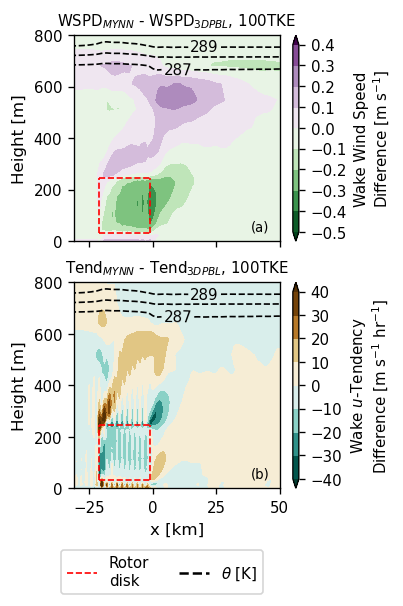

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(2.5,5), sharex=True, sharey=True, dpi=120)

for axs in ax.reshape(-1):
    axs.set_box_aspect(1)
    axs.tick_params(labelsize=9)

    axs.set_xticks([-25, 0, 25, 50])
    
    axs.plot([-21, -21], [rotor_bot, rotor_top], ls='--', color='r', lw=1, label='Rotor\ndisk')
    axs.plot([-1, -1], [rotor_bot, rotor_top], ls='--', color='r', lw=1)
    axs.plot([-21, -1], [rotor_bot, rotor_bot], ls='--', color='r', lw=1)
    axs.plot([-21, -1], [rotor_top, rotor_top], ls='--', color='r', lw=1)
    
ax[0].set_xlim(-31,50)
ax[0].set_ylim(0,800)
ax[0].set_ylabel("Height [m]")
ax[1].set_ylabel("Height [m]")
ax[1].set_xlabel("x [km]")
    
ax[0].set_title('WSPD$_{MYNN}$ - WSPD$_{3DPBL}$, 100TKE', fontsize=9)
ax[1].set_title('Tend$_{MYNN}$ - Tend$_{3DPBL}$, 100TKE', fontsize=9)
    
## Plot parameters
ticks_left = np.arange(-0.5, 0.5, 0.1)
ticks_right = np.arange(-40, 50, 10)
ticks_t = np.arange(286, 290, 1)
j_ind = 101
j_ind_min = 89
j_ind_max = 109
    
## Select wind speed slices
wspd_nm = dsn_m['WSPD'].isel(south_north=slice(j_ind_min,j_ind_max)).mean('south_north')
wspd_tm = dst_m['WSPD'].isel(south_north=slice(j_ind_min,j_ind_max)).mean('south_north')
wspd_zm = dsz_m['WSPD'].isel(south_north=slice(j_ind_min,j_ind_max)).mean('south_north')
wspd_nhv = dsn_hv['WSPD'].isel(south_north=slice(j_ind_min,j_ind_max)).mean('south_north')
wspd_thv = dst_hv['WSPD'].isel(south_north=slice(j_ind_min,j_ind_max)).mean('south_north')
wspd_zhv = dsz_hv['WSPD'].isel(south_north=slice(j_ind_min,j_ind_max)).mean('south_north')


## Select tendency slices
utend_nm = -1*dsn_m_utend_z.isel(south_north=slice(j_ind_min,j_ind_max)).mean('south_north')
utend_tm = -1*dst_m_utend_z.isel(south_north=slice(j_ind_min,j_ind_max)).mean('south_north')
utend_zm = -1*dsz_m_utend_z.isel(south_north=slice(j_ind_min,j_ind_max)).mean('south_north')
utend_nhv = -1*dsn_hv_utend_z.isel(south_north=slice(j_ind_min,j_ind_max)).mean('south_north')
utend_thv = -1*dst_hv_utend_z.isel(south_north=slice(j_ind_min,j_ind_max)).mean('south_north')
utend_zhv = -1*dsz_hv_utend_z.isel(south_north=slice(j_ind_min,j_ind_max)).mean('south_north')

im1 = ax[0].contourf(iunstag_arr,
                        heights,
                        (wspd_tm-wspd_nm)-(wspd_thv-wspd_nhv),
                        ticks_left,
                        cmap=plt.cm.PRGn_r, norm=TwoSlopeNorm(0, vmin=-1*np.abs(ticks_left).max(), vmax=np.abs(ticks_left).max()),
                        extend='both')
im2 = ax[1].contourf(iunstag_arr,
                        heights_stag,
                        (utend_tm-utend_nm)-(utend_thv-utend_nhv),
                        ticks_right,
                        cmap=plt.cm.BrBG_r, norm=TwoSlopeNorm(0, vmin=-1*np.abs(ticks_right).max(), vmax=np.abs(ticks_right).max()),
                        extend='both')

## Select temperature slices
t_nm = dsn_m['T'].isel(south_north=slice(j_ind_min,j_ind_max)).mean('south_north')
t_tm = dst_m['T'].isel(south_north=slice(j_ind_min,j_ind_max)).mean('south_north')
t_zm = dsz_m['T'].isel(south_north=slice(j_ind_min,j_ind_max)).mean('south_north')
t_nhv = dsn_hv['T'].isel(south_north=slice(j_ind_min,j_ind_max)).mean('south_north')
t_thv = dst_hv['T'].isel(south_north=slice(j_ind_min,j_ind_max)).mean('south_north')
t_zhv = dsz_hv['T'].isel(south_north=slice(j_ind_min,j_ind_max)).mean('south_north')
    
CS = ax[0].contour(iunstag_arr,
                   heights,
                   t_tm,
                   ticks_t,
                   colors='k',
                   linestyles='dashed',
                   linewidths=1)
manual_locations = [(10.0, 650), (20.5, 850)]
ax[0].clabel(CS, inline=True, manual=manual_locations, fmt='%3.0f', fontsize=9)


CS = ax[1].contour(iunstag_arr,
                   heights,
                   t_tm,
                   ticks_t,
                   colors='k',
                   linestyles='dashed',
                   linewidths=1)
manual_locations = [(10.0, 650), (20.5, 850)]
ax[1].clabel(CS, inline=True, manual=manual_locations, fmt='%3.0f', fontsize=9)

cax1 = fig.add_axes([ax[0].get_position().x0+0.73,
                     ax[0].get_position().y0,
                     0.02,
                     ax[0].get_position().y1-ax[0].get_position().y0])
cbar1 = fig.colorbar(im1, cax=cax1, ticks=ticks_left)
cbar1.set_label('Wake Wind Speed\nDifference [m s$^{-1}$]', fontsize=9)
cbar1.ax.tick_params(labelsize=9)     

cax2 = fig.add_axes([ax[0].get_position().x0+0.73,
                     ax[1].get_position().y0,
                     0.02,
                     ax[0].get_position().y1-ax[0].get_position().y0])
cbar2 = fig.colorbar(im2, cax=cax2, ticks=ticks_right)
cbar2.set_label('Wake $u$-Tendency\nDifference [m s$^{-1}$ hr$^{-1}$]', fontsize=9)
cbar2.ax.tick_params(labelsize=9)     


ax[0].plot([-9999, -9999], [0, 1], ls='--', color='k', label='$\\theta$ [K]')
handles, labels = ax[0].get_legend_handles_labels()
lgd = ax[1].legend(handles, labels, bbox_to_anchor=(-0.1, -0.55), loc='lower left', fontsize=9,
                      ncol=2)
    
## Subpanel labels
for axs, letter in zip(ax.flatten(), list(string.ascii_lowercase)):
    axs.text(0.95,
          0.05,
          f'({letter})',
          fontsize=8,
          transform = axs.transAxes,
          horizontalalignment='right',
            color='black')
    
# plt.savefig('../../figs/neutral_wake_tendencies_100TKE.pdf', bbox_inches='tight')
    
plt.show()